In [1]:
#pip install -U scikit-learn

In [2]:
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sns

from tqdm import tqdm

import shutil

In [3]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

100%|██████████| 1.08G/1.08G [00:14<00:00, 80.9MB/s]

Extracting files...


In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
NUM_CLASS = 13

EPOCHS = 30

device = torch.device('cuda')

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [5]:
import os
import pandas

input_dir = DATASET_PATH + "/simpsons_dataset"

character_counts = {}

data = []

for character_folder in os.listdir(input_dir):
    character_folder_path = os.path.join(input_dir, character_folder)

    if os.path.isdir(character_folder_path):
        num_files = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
        character_counts[character_folder] = num_files

    for character_folder in os.listdir(input_dir):
        character_folder_path = os.path.join(input_dir, character_folder)
        if os.path.isdir(character_folder_path):
            for filename in os.listdir(character_folder_path):
                file_path = os.path.join(character_folder_path, filename)
                if os.path.isfile(file_path):
                    data.append([character_folder, file_path])

df = pandas.DataFrame(data, columns=["character_folder", "filename"])

In [6]:
allowed_classes = []

sorted_counts = list(sorted(character_counts.items(), key=lambda x: -x[1]))
for character, count in sorted_counts:
    print(f"{character}: {count} images")
    allowed_classes.append(character)

allowed_classes = allowed_classes[:NUM_CLASS]

homer_simpson: 2246 images
ned_flanders: 1454 images
moe_szyslak: 1452 images
lisa_simpson: 1354 images
bart_simpson: 1342 images
marge_simpson: 1291 images
krusty_the_clown: 1206 images
principal_skinner: 1194 images
charles_montgomery_burns: 1193 images
milhouse_van_houten: 1079 images
chief_wiggum: 986 images
abraham_grampa_simpson: 913 images
sideshow_bob: 877 images
apu_nahasapeemapetilon: 623 images
kent_brockman: 498 images
comic_book_guy: 469 images
edna_krabappel: 457 images
nelson_muntz: 358 images
lenny_leonard: 310 images
mayor_quimby: 246 images
waylon_smithers: 181 images
maggie_simpson: 128 images
groundskeeper_willie: 121 images
barney_gumble: 106 images
selma_bouvier: 103 images
carl_carlson: 98 images
ralph_wiggum: 89 images
patty_bouvier: 72 images
martin_prince: 71 images
professor_john_frink: 65 images
snake_jailbird: 55 images
cletus_spuckler: 47 images
rainier_wolfcastle: 45 images
agnes_skinner: 42 images
sideshow_mel: 40 images
otto_mann: 32 images
fat_tony: 27

In [7]:
df[:5]

,character_folder,filename
0,carl_carlson,/root/.cache/kagglehub/datasets/alexattia/the-...
1,carl_carlson,/root/.cache/kagglehub/datasets/alexattia/the-...
2,carl_carlson,/root/.cache/kagglehub/datasets/alexattia/the-...
3,carl_carlson,/root/.cache/kagglehub/datasets/alexattia/the-...
4,carl_carlson,/root/.cache/kagglehub/datasets/alexattia/the-...


In [8]:
class_weights = {}
max_samples = max(character_counts[class_name] for class_name in allowed_classes)

for idx, class_name in enumerate(allowed_classes):
    weight = max_samples / character_counts[class_name]
    class_weights[idx] = weight

for idx, class_name in enumerate(allowed_classes):
    print(f"{class_name}: {class_weights[idx]:.2f} (Number of images: {character_counts[class_name]})")

homer_simpson: 1.00 (Number of images: 2246)
ned_flanders: 1.54 (Number of images: 1454)
moe_szyslak: 1.55 (Number of images: 1452)
lisa_simpson: 1.66 (Number of images: 1354)
bart_simpson: 1.67 (Number of images: 1342)
marge_simpson: 1.74 (Number of images: 1291)
krusty_the_clown: 1.86 (Number of images: 1206)
principal_skinner: 1.88 (Number of images: 1194)
charles_montgomery_burns: 1.88 (Number of images: 1193)
milhouse_van_houten: 2.08 (Number of images: 1079)
chief_wiggum: 2.28 (Number of images: 986)
abraham_grampa_simpson: 2.46 (Number of images: 913)
sideshow_bob: 2.56 (Number of images: 877)


In [9]:
output_dir = "./dataset_filtered"

os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in allowed_classes:
    class_path = os.path.join(input_dir, class_name)
    all_images = sorted(os.listdir(class_path))
    train_files, temp_files = train_test_split(all_images, train_size=TRAIN_SIZE, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=TEST_SIZE / (1 - TRAIN_SIZE), random_state=42)

    for subset, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        subset_class_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        for file_name in subset_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(subset_class_dir, file_name)
            shutil.copy(src_file, dst_file)

    print(f"Processing completed for '{class_name}'.")

Processing completed for 'homer_simpson'.
Processing completed for 'ned_flanders'.
Processing completed for 'moe_szyslak'.
Processing completed for 'lisa_simpson'.
Processing completed for 'bart_simpson'.
Processing completed for 'marge_simpson'.
Processing completed for 'krusty_the_clown'.
Processing completed for 'principal_skinner'.
Processing completed for 'charles_montgomery_burns'.
Processing completed for 'milhouse_van_houten'.
Processing completed for 'chief_wiggum'.
Processing completed for 'abraham_grampa_simpson'.
Processing completed for 'sideshow_bob'.


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
class SimpsonClassifierCNNNet(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Conv
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        # --- Batchnorm
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.bnfc = nn.BatchNorm1d(576)

        # --- Activation
        self.relu = nn.ReLU()

        # --- Xaxpool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # --- FC
        self.fc1 = nn.Linear(1024, 576)
        self.fc2 = nn.Linear(576, len(allowed_classes))

        # --- Dropout
        self.dropout = nn.Dropout(0.2)
        self.dropoutfc = nn.Dropout(0.5)


    def forward(self, x):
        # --- conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- flatten
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # --- classification
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bnfc(x)
        x = self.dropoutfc(x)

        x = self.fc2(x)

        return x


In [12]:
model = SimpsonClassifierCNNNet()
model.to(device)

SimpsonClassifierCNNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
weights_tensor = torch.tensor([class_weights[idx] for idx in range(len(allowed_classes))], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [15]:
metrics_df = pandas.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

In [16]:
for epoch in range(EPOCHS):
    # --- train
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    loop = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{EPOCHS}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loss = running_loss / (loop.n + 1)
        train_acc = correct / total

        loop.set_description(f"Эпоха {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # --- validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(validation_loader)
    val_acc = val_correct / val_total

    new_row = pandas.DataFrame([{
    "Epoch": epoch + 1,
    "Train Loss": running_loss / (loop.n + 1),
    "Train Accuracy": correct / total,
    "Val Loss": val_loss,
    "Val Accuracy": val_acc
    }])
    metrics_df = pandas.concat([metrics_df, new_row], ignore_index=True)

    print(f"Эпоха {epoch+1}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}")

Эпоха 1/30, Train Loss: 1.8288, Train Acc: 0.3941: 100%|██████████| 91/91 [01:20<00:00,  1.13it/s]
<ipython-input-16-c3919e21f249>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pandas.concat([metrics_df, new_row], ignore_index=True)


Эпоха 1: Val Loss = 1.6369, Val Accuracy = 0.4910


Эпоха 2/30, Train Loss: 0.9845, Train Acc: 0.6622: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Эпоха 2: Val Loss = 1.6152, Val Accuracy = 0.5404


Эпоха 3/30, Train Loss: 0.6803, Train Acc: 0.7658: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 3: Val Loss = 0.7724, Val Accuracy = 0.7557


Эпоха 4/30, Train Loss: 0.5018, Train Acc: 0.8291: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 4: Val Loss = 1.0096, Val Accuracy = 0.6822


Эпоха 5/30, Train Loss: 0.3995, Train Acc: 0.8662: 100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


Эпоха 5: Val Loss = 0.4973, Val Accuracy = 0.8485


Эпоха 6/30, Train Loss: 0.3278, Train Acc: 0.8915: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Эпоха 6: Val Loss = 0.5034, Val Accuracy = 0.8465


Эпоха 7/30, Train Loss: 0.2583, Train Acc: 0.9167: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 7: Val Loss = 0.6426, Val Accuracy = 0.8252


Эпоха 8/30, Train Loss: 0.2191, Train Acc: 0.9280: 100%|██████████| 91/91 [01:18<00:00,  1.15it/s]


Эпоха 8: Val Loss = 0.4042, Val Accuracy = 0.8803


Эпоха 9/30, Train Loss: 0.1932, Train Acc: 0.9355: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Эпоха 9: Val Loss = 0.3959, Val Accuracy = 0.8811


Эпоха 10/30, Train Loss: 0.1672, Train Acc: 0.9435: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 10: Val Loss = 0.6395, Val Accuracy = 0.8164


Эпоха 11/30, Train Loss: 0.1294, Train Acc: 0.9578: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 11: Val Loss = 0.5203, Val Accuracy = 0.8501


Эпоха 12/30, Train Loss: 0.1103, Train Acc: 0.9642: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Эпоха 12: Val Loss = 0.4330, Val Accuracy = 0.8859


Эпоха 13/30, Train Loss: 0.1028, Train Acc: 0.9650: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 13: Val Loss = 0.5819, Val Accuracy = 0.8401


Эпоха 14/30, Train Loss: 0.0853, Train Acc: 0.9723: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 14: Val Loss = 0.3706, Val Accuracy = 0.8984


Эпоха 15/30, Train Loss: 0.0776, Train Acc: 0.9760: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 15: Val Loss = 0.4369, Val Accuracy = 0.8883


Эпоха 16/30, Train Loss: 0.0657, Train Acc: 0.9783: 100%|██████████| 91/91 [01:18<00:00,  1.15it/s]


Эпоха 16: Val Loss = 0.2701, Val Accuracy = 0.9289


Эпоха 17/30, Train Loss: 0.0518, Train Acc: 0.9829: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 17: Val Loss = 0.2567, Val Accuracy = 0.9373


Эпоха 18/30, Train Loss: 0.0453, Train Acc: 0.9852: 100%|██████████| 91/91 [01:18<00:00,  1.15it/s]


Эпоха 18: Val Loss = 0.2849, Val Accuracy = 0.9269


Эпоха 19/30, Train Loss: 0.0459, Train Acc: 0.9848: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Эпоха 19: Val Loss = 0.3051, Val Accuracy = 0.9176


Эпоха 20/30, Train Loss: 0.0476, Train Acc: 0.9842: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Эпоха 20: Val Loss = 0.2131, Val Accuracy = 0.9490


Эпоха 21/30, Train Loss: 0.0425, Train Acc: 0.9865: 100%|██████████| 91/91 [01:18<00:00,  1.15it/s]


Эпоха 21: Val Loss = 0.2257, Val Accuracy = 0.9454


Эпоха 22/30, Train Loss: 0.0324, Train Acc: 0.9905: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 22: Val Loss = 0.2389, Val Accuracy = 0.9409


Эпоха 23/30, Train Loss: 0.0422, Train Acc: 0.9857: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 23: Val Loss = 0.2298, Val Accuracy = 0.9490


Эпоха 24/30, Train Loss: 0.0283, Train Acc: 0.9910: 100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


Эпоха 24: Val Loss = 0.2291, Val Accuracy = 0.9494


Эпоха 25/30, Train Loss: 0.0203, Train Acc: 0.9943: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 25: Val Loss = 0.3671, Val Accuracy = 0.9040


Эпоха 26/30, Train Loss: 0.0290, Train Acc: 0.9911: 100%|██████████| 91/91 [01:18<00:00,  1.15it/s]


Эпоха 26: Val Loss = 0.1978, Val Accuracy = 0.9562


Эпоха 27/30, Train Loss: 0.0217, Train Acc: 0.9932: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 27: Val Loss = 0.2470, Val Accuracy = 0.9446


Эпоха 28/30, Train Loss: 0.0352, Train Acc: 0.9873: 100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


Эпоха 28: Val Loss = 0.3658, Val Accuracy = 0.9136


Эпоха 29/30, Train Loss: 0.0380, Train Acc: 0.9872: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Эпоха 29: Val Loss = 0.3068, Val Accuracy = 0.9325


Эпоха 30/30, Train Loss: 0.0388, Train Acc: 0.9883: 100%|██████████| 91/91 [01:22<00:00,  1.10it/s]


Эпоха 30: Val Loss = 0.3331, Val Accuracy = 0.9213


In [17]:
metrics_df.to_csv("model.csv", index=False)
torch.save(model.state_dict(), 'model.pth')

In [18]:
model.load_state_dict(torch.load('model.pth', map_location=device))
model.eval()

<ipython-input-18-d8ab9da5be89>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=device))


SimpsonClassifierCNNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine

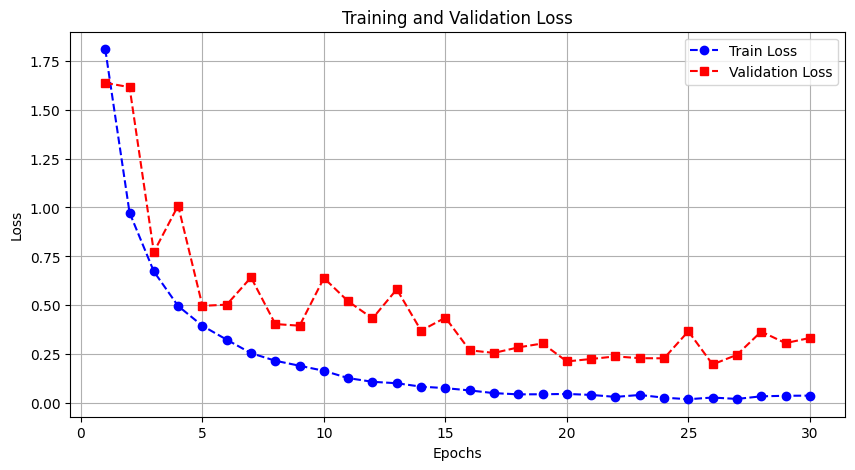

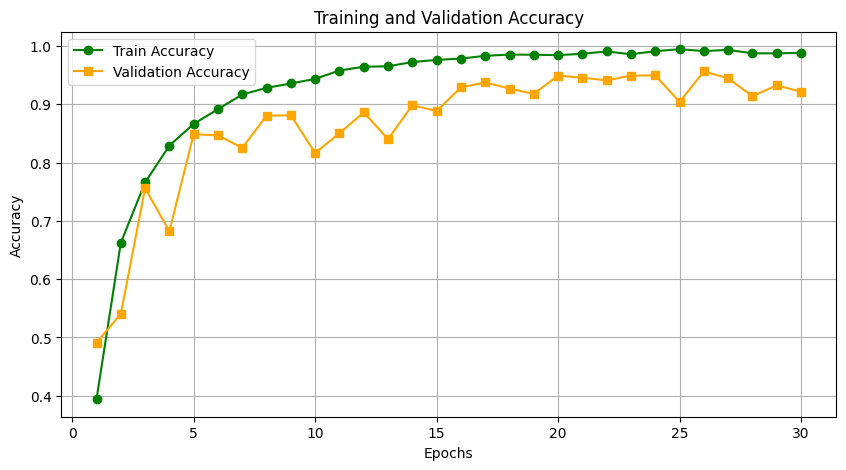

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "model.csv"
df = pd.read_csv(file_path)

epochs = df["Epoch"]
train_loss = df["Train Loss"]
train_acc = df["Train Accuracy"]
val_loss = df["Val Loss"]
val_acc = df["Val Accuracy"]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", color='blue', linestyle='dashed', marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", color='red', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Построение графиков точности
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", color='green', linestyle='solid', marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='orange', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [20]:
import numpy as np

y_true = []
y_pred = []

for batch_images, batch_labels in tqdm(test_loader):
    batch_images = batch_images.to(device)
    batch_predictions = model(batch_images)
    batch_pred_labels = np.argmax(batch_predictions.detach().cpu().numpy(), axis=1)

    y_true.extend(batch_labels.detach().cpu().numpy())
    y_pred.extend(batch_pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


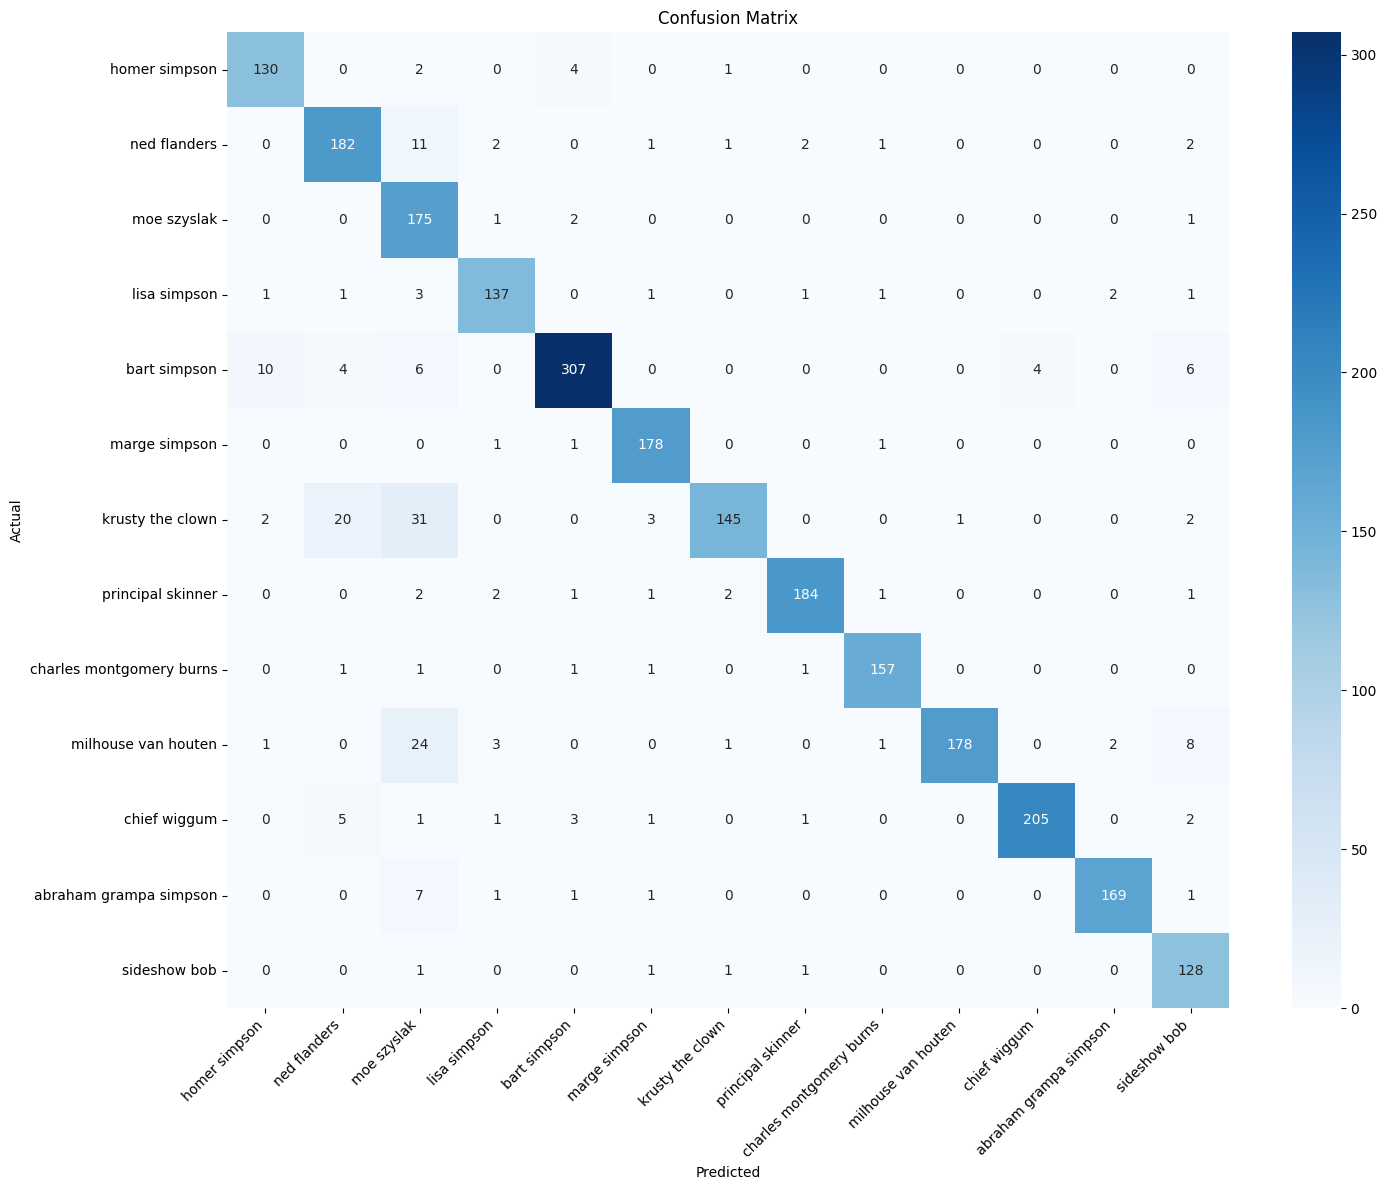

In [21]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[name.replace('_', ' ') for name in allowed_classes],
            yticklabels=[name.replace('_', ' ') for name in allowed_classes])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
num_classes = len(np.unique(y_true))  # Определяем количество классов
class_accuracies = {}

for cls in range(num_classes):
    cls_mask = (y_true == cls)
    class_accuracies[cls] = accuracy_score(y_true[cls_mask], y_pred[cls_mask])

for cls, acc in class_accuracies.items():
    print(f"Class {allowed_classes[cls]}: Accuracy = {acc:.4f}")

Class homer_simpson: Accuracy = 0.9489
Class ned_flanders: Accuracy = 0.9010
Class moe_szyslak: Accuracy = 0.9777
Class lisa_simpson: Accuracy = 0.9257
Class bart_simpson: Accuracy = 0.9110
Class marge_simpson: Accuracy = 0.9834
Class krusty_the_clown: Accuracy = 0.7108
Class principal_skinner: Accuracy = 0.9485
Class charles_montgomery_burns: Accuracy = 0.9691
Class milhouse_van_houten: Accuracy = 0.8165
Class chief_wiggum: Accuracy = 0.9361
Class abraham_grampa_simpson: Accuracy = 0.9389
Class sideshow_bob: Accuracy = 0.9697
